### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

Some parameters

In [3]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

DATASET_SIZE = len(list(data_dir.glob('*/*.png')))

EPOCHS = 5
BATCH_SIZE = 128
IMG_HEIGHT = 64 #224
IMG_WIDTH = 64
STEPS_PER_EPOCH = np.ceil(DATASET_SIZE/BATCH_SIZE)

In [4]:
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])

for classes in class_names:
    class_samples = len(list(data_dir.glob(classes+'/*.png')))
    print('{0:18}: {1:3d}'.format(classes, class_samples))

print ('\nTotal number of images:', DATASET_SIZE)

Anatomic landmarks: 6868
Unknown           : 274
Protruding lesions: 583
Flat lesions      : 908
Lumen             : 1446
Mucosa            : 251
Normal            : 33129
Excavated lesions : 1252

Total number of images: 44711


### Loading images with `tf.data.Dataset`.

In [5]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Show some examples
for path in list_ds.take(5):
    print(path.numpy())

b'/mnt/sdb/augere_export_class/Normal/8885668afb844852_115_22885.png'
b'/mnt/sdb/augere_export_class/Normal/d369e4f163df4aba_124_6888.png'
b'/mnt/sdb/augere_export_class/Anatomic landmarks/04a78ef00c5245e0_23_48752.png'
b'/mnt/sdb/augere_export_class/Normal/bca26705313a4644_123_10148.png'
b'/mnt/sdb/augere_export_class/Normal/495f16498db34d3c_135_21156.png'


A short pure-tensorflow function that converts a file path to an `image_data, label` pair:

In [6]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Using `Dataset.map` to create a dataset of `Image, label` pairs:

In [7]:
# Set 'num_parallel_calls' so multiple images are loaded and processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [8]:
for image, label in labeled_ds.take(1):
    print ('Image shape: ', image.numpy().shape)
    print ('Label: ', label.numpy())

Image shape:  (64, 64, 3)
Label:  [False False False False False False  True False]


### Prepare dataset for training
Want the data to be shuffled and batched. Here we use the `tf.data` api.

In [9]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Split into training, test and validation dataset

In [36]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_ds = labeled_ds
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [39]:
num_elements = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements)

6708


In [40]:
# Create training dataset
train_ds = prepare_for_training(train_ds)
# Create test dataset
test_ds = prepare_for_training(test_ds)
# Create validation dataset
val_ds = prepare_for_training(val_ds)

In [23]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

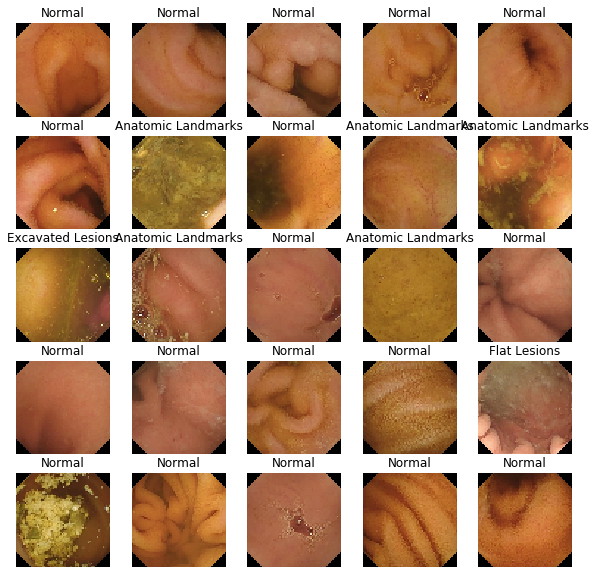

In [26]:
# Get one batch 
image_batch, label_batch = next(iter(train_ds))

# Display images in current batch
show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
import time
default_timeit_steps = 100

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [ ]:
# Prepare dataset with cache
timeit(train_ds)

In [ ]:
# Prepare dataset without cahce
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

In [ ]:
# Prepare dataset with chache file (in case ds dont fit in memory)
filecache_ds = prepare_for_training(labeled_ds, cache="./kvasir_ds.tfcache")
timeit(filecache_ds)

## Traning

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Create the model

In [16]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compile the model

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [41]:
history = model.fit_generator(
    train_ds,
    steps_per_epoch = train_size // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    validation_steps = val_size // BATCH_SIZE
)

Epoch 1/5
244/244 [==============================] - 190s 777ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750
Epoch 2/5
244/244 [==============================] - 7s 29ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750
Epoch 3/5
244/244 [==============================] - 7s 29ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750
Epoch 4/5
244/244 [==============================] - 7s 28ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750
Epoch 5/5
244/244 [==============================] - 7s 29ms/step - loss: 0.3768 - accuracy: 0.8750 - val_loss: 0.3768 - val_accuracy: 0.8750


Visualize training results

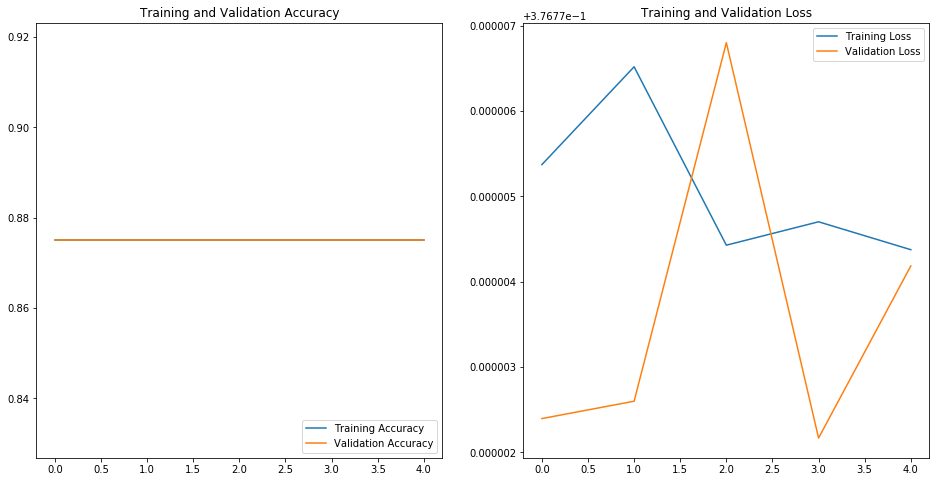

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()